# 1.1 Imports

In [1]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline

from datetime import datetime

from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp, round
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# create parksession

spark = SparkSession.builder.master('local') \
        .appName('Sparkify').getOrCreate()

21/08/16 14:32:53 WARN Utils: Your hostname, Yats-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.192.135.205 instead (on interface en0)
21/08/16 14:32:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/16 14:32:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# load data

path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
# check schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# 1.2 Missing Values

# 1.2.1 Observations

In [6]:
# total number of rows
print(f'total number of rows: {df.count()}')

total number of rows: 286500


In [7]:
# number of missing values

for c in df.columns:
    df.select(
        [count(when(df[c].isNull(),True))]
    ).show()

+-----------------------------------------------+
|count(CASE WHEN (artist IS NULL) THEN true END)|
+-----------------------------------------------+
|                                          58392|
+-----------------------------------------------+



+---------------------------------------------+
|count(CASE WHEN (auth IS NULL) THEN true END)|
+---------------------------------------------+
|                                            0|
+---------------------------------------------+



+--------------------------------------------------+
|count(CASE WHEN (firstName IS NULL) THEN true END)|
+--------------------------------------------------+
|                                              8346|
+--------------------------------------------------+

+-----------------------------------------------+
|count(CASE WHEN (gender IS NULL) THEN true END)|
+-----------------------------------------------+
|                                           8346|
+-----------------------------------------------+



+------------------------------------------------------+
|count(CASE WHEN (itemInSession IS NULL) THEN true END)|
+------------------------------------------------------+
|                                                     0|
+------------------------------------------------------+



+-------------------------------------------------+
|count(CASE WHEN (lastName IS NULL) THEN true END)|
+-------------------------------------------------+
|                                             8346|
+-------------------------------------------------+



+-----------------------------------------------+
|count(CASE WHEN (length IS NULL) THEN true END)|
+-----------------------------------------------+
|                                          58392|
+-----------------------------------------------+

+----------------------------------------------+
|count(CASE WHEN (level IS NULL) THEN true END)|
+----------------------------------------------+
|                                             0|
+----------------------------------------------+



+-------------------------------------------------+
|count(CASE WHEN (location IS NULL) THEN true END)|
+-------------------------------------------------+
|                                             8346|
+-------------------------------------------------+



+-----------------------------------------------+
|count(CASE WHEN (method IS NULL) THEN true END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+

+---------------------------------------------+
|count(CASE WHEN (page IS NULL) THEN true END)|
+---------------------------------------------+
|                                            0|
+---------------------------------------------+



+-----------------------------------------------------+
|count(CASE WHEN (registration IS NULL) THEN true END)|
+-----------------------------------------------------+
|                                                 8346|
+-----------------------------------------------------+



+--------------------------------------------------+
|count(CASE WHEN (sessionId IS NULL) THEN true END)|
+--------------------------------------------------+
|                                                 0|
+--------------------------------------------------+



+---------------------------------------------+
|count(CASE WHEN (song IS NULL) THEN true END)|
+---------------------------------------------+
|                                        58392|
+---------------------------------------------+



+-----------------------------------------------+
|count(CASE WHEN (status IS NULL) THEN true END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



+-------------------------------------------+
|count(CASE WHEN (ts IS NULL) THEN true END)|
+-------------------------------------------+
|                                          0|
+-------------------------------------------+



+--------------------------------------------------+
|count(CASE WHEN (userAgent IS NULL) THEN true END)|
+--------------------------------------------------+
|                                              8346|
+--------------------------------------------------+

+-----------------------------------------------+
|count(CASE WHEN (userId IS NULL) THEN true END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



# 1.2.2 Missing Values in userId

In [8]:
# from above findings, 0 rows in userId is NULL
# so we check for samples

df.select(['userId']).drop_duplicates().orderBy(df['userId']).show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [9]:
# the first row is an empty string

In [10]:
# create a temporary view for running SQL queries
df.createOrReplaceTempView('df_table')

In [11]:
# display the page events of the user with empty string userId

spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ''
    '''
).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [12]:
# display the page events of another user with non-empty string userId

spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == 100001
    '''
).show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|         Thumbs Down|
|                Home|
|         Roll Advert|
|              Logout|
|Cancellation Conf...|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
+--------------------+



In [13]:
# we can see that 
# the page events of empty string userId user has nearly no features page except
# 'Submit Registration' which might indicate that it is a user with incomplete registration

In [14]:
# drop the row with empty userId
df = df.filter(df['userId'] != '')

# 1.3 Feature Engineering

# 1.3.1 Overview of Numerical Features

In [15]:
# number of unique users

unique_users = df.select('userId').drop_duplicates().count()
print(unique_users)

225


In [16]:
# numerical columns
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']

In [17]:
# describe numerical columns
df.select(num_cols).describe().show()

+-------+------------------+--------------------+------------------+--------------------+-----------------+
|summary|     itemInSession|        registration|            status|                  ts|           length|
+-------+------------------+--------------------+------------------+--------------------+-----------------+
|  count|            278154|              278154|            278154|              278154|           228108|
|   mean|114.89918174824018|1.535358834084427...|209.10321620397335|1.540958915431871...|249.1171819778458|
| stddev|  129.851729399489| 3.291321616327586E9|30.151388851328214|1.5068287123306298E9|99.23517921058361|
|    min|                 0|       1521380675000|               200|       1538352117000|          0.78322|
|    max|              1321|       1543247354000|               404|       1543799476000|       3024.66567|
+-------+------------------+--------------------+------------------+--------------------+-----------------+



In [18]:
# 'status' is HTTP status

header = 'status'
df.groupBy(header).count() \
.withColumn('%', round((col('count')/df.count())*100,2)) \
.orderBy('%', ascending=False).show()

+------+------+-----+
|status| count|    %|
+------+------+-----+
|   200|254718|91.57|
|   307| 23184| 8.33|
|   404|   252| 0.09|
+------+------+-----+



In [19]:
# 'status' should be classified as categorical feature

# 1.3.2 Overview of Categorical Features

In [20]:
# catagorical columns
cat_cols = [
    'artist', 'auth', 'firstName', 'lastName', 
    'gender', 'level', 'location','method', 
    'page', 'song', 'userAgent'
]

In [21]:
# we only observe the features that can be classified

In [22]:
# values count of 'auth'

header = 'auth'
df.groupBy(header).count() \
.withColumn('%', round((col('count')/df.count())*100,2)) \
.orderBy('%', ascending=False).show()

+---------+------+-----+
|     auth| count|    %|
+---------+------+-----+
|Logged In|278102|99.98|
|Cancelled|    52| 0.02|
+---------+------+-----+



In [23]:
# values count of 'gender'

header = 'gender'
df.groupBy(header).count() \
.withColumn('%', round((col('count')/df.count())*100,2)) \
.orderBy('%', ascending=False).show()

+------+------+-----+
|gender| count|    %|
+------+------+-----+
|     F|154578|55.57|
|     M|123576|44.43|
+------+------+-----+



In [24]:
# values count of 'level'

header = 'level'
df.groupBy(header).count() \
.withColumn('%', round((col('count')/df.count())*100,2)) \
.orderBy('%', ascending=False).show()

+-----+------+-----+
|level| count|    %|
+-----+------+-----+
| paid|222433|79.97|
| free| 55721|20.03|
+-----+------+-----+



In [25]:
# first 5 values count of 'location'

header = 'location'
df.groupBy(header).count() \
.withColumn('%', round((col('count')/df.count())*100,2)) \
.orderBy('%', ascending=False).limit(5).show()

+--------------------+-----+-----+
|            location|count|    %|
+--------------------+-----+-----+
|Los Angeles-Long ...|30131|10.83|
|New York-Newark-J...|23684| 8.51|
|Boston-Cambridge-...|13873| 4.99|
|Houston-The Woodl...| 9499| 3.42|
|Charlotte-Concord...| 7780|  2.8|
+--------------------+-----+-----+



In [26]:
# values count of 'method'

header = 'method'
df.groupBy(header).count() \
.withColumn('%', round((col('count')/df.count())*100,2)) \
.orderBy('%', ascending=False).show()

+------+------+-----+
|method| count|    %|
+------+------+-----+
|   PUT|257818|92.69|
|   GET| 20336| 7.31|
+------+------+-----+



In [27]:
# unique values of 'page'

header = 'page'
print([x[header] for x in df.select(header).drop_duplicates().collect()])

['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


# 1.3.3 Define Churn

In [28]:
# churn can be detected by the appearance of 'Cancellation Confirmation' in column 'page'

In [29]:
# define function
churn = udf(lambda x: 1 if 'Cancellation Confirmation' in x else 0, IntegerType())

# create feature of churn
df = df.withColumn('churned', churn('page'))

In [30]:
# distribution of 'churned' over the no of unique users

df.groupBy('userId').agg({'churned':'sum'}).select(avg('sum(churned)')).show()

+------------------+
| avg(sum(churned))|
+------------------+
|0.2311111111111111|
+------------------+



In [31]:
# 23.1% of users have churned

In [32]:
# create feature of churned users
df = df.withColumn('user_churn', max('churned').over(Window.partitionBy('UserId')))

In [33]:
df.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churned=0, user_churn=0)]

In [34]:
# convert timestamp format
format_ts = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime('%m-%d-%Y %H:%M:%S'))

# convert 'registration' column
df = df.withColumn('registration_datetime', format_ts('registration'))

# convert 'ts' column
df = df.withColumn('event_datetime', format_ts('ts'))

In [35]:
# observe first item
df.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churned=0, user_churn=0, registration_datetime='09-27-2018 10:45:40', event_datetime='10-08-2018 20:58:54')]

In [36]:
# display first 10 unique userId with selected columns

df.select(['userId', 'firstName', 'lastName', 'level', 'registration_datetime', 'user_churn']).drop_duplicates(['userId']).show(10)

+------+---------+---------+-----+---------------------+----------+
|userId|firstName| lastName|level|registration_datetime|user_churn|
+------+---------+---------+-----+---------------------+----------+
|100010| Darianna|Carpenter| free|  09-27-2018 10:45:40|         0|
|200002|  Dominic|   Torres| free|  09-07-2018 05:38:26|         0|
|   125|    Mason|     Hart| free|  08-02-2018 04:58:59|         1|
|   124|   Nicole|     Beck| paid|  07-22-2018 09:52:15|         0|
|    51|    Ethan|  Johnson| paid|  09-28-2018 04:43:07|         1|
|     7|   Maddox|  Johnson| free|  09-11-2018 20:06:16|         0|
|    15|    Panav|    Myers| paid|  09-30-2018 00:37:25|         0|
|    54|    Alexi|   Warren| paid|  07-25-2018 09:37:42|         1|
|   155|   Camila| Calderon| free|  11-05-2018 06:27:50|         0|
|100014|  Rodrigo|    Carey| paid|  08-28-2018 01:04:03|         1|
+------+---------+---------+-----+---------------------+----------+
only showing top 10 rows



In [37]:
# (unsuccessful) save data
# df.write.save('mini_sparkify_cleaned.json', format='json')

# it was saved into a folder of 200 partition json files

# 1.4 Exploratory Data Analysis

In [38]:
# andy p w yu
# 1. churn uers by gender
# 2. paid/free customers churn 
# 3. no of songs played per session
# 4. membership period (time since registration) [critical period to make users stay]
# 5. no of friends 

## angang li
# (X)6. paid/free churn ratio
# 7. page event (12 boxplots!) don't need distribution
# 8. thumbsup/down
# 9. locations [geographically different user habits]

# advertisement/ marketing/ strategy
# 1, 2

# user experience/ product research
# 3, 4, 5, 7, 8, 

# clustering/ segmentation
# 9

# 1.4.1 Advertisement/ Marketing

# 1.4.1.1 Genders

In [39]:
# gender distribution

df_gender_pd = df.drop_duplicates(['userId', 'gender'])\
    .groupby(['user_churn', 'gender']).count().sort('gender').toPandas()
df_gender_pd

,user_churn,gender,count
0,1,F,20
1,0,F,84
2,0,M,89
3,1,M,32


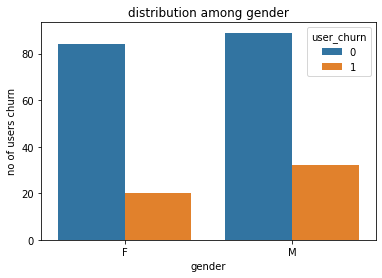

In [67]:
# display in bar chart

sns.barplot(x = 'gender', y = 'count', data = df_gender_pd, hue = 'user_churn')

plt.title('distribution among genders')
plt.ylabel('no of users churn')
plt.show()

In [41]:
# Male users have a higher rate of churning than female users
# it may indicate that female users have a higher level of customer loyalty

# 1.4.1.2 Levels of Subscription

In [42]:
# 2 levels of subcription (free/paid) distribution

df_level_pd = df.drop_duplicates(['userId', 'level'])\
    .groupby(['user_churn', 'level']).count().sort('level').toPandas()
df_level_pd

,user_churn,level,count
0,0,free,149
1,1,free,46
2,0,paid,129
3,1,paid,36


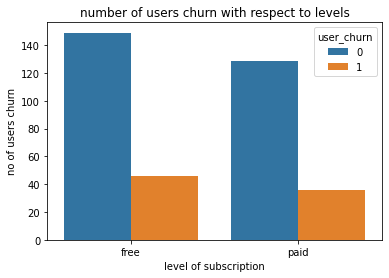

In [66]:
# display in bar chart

sns.barplot(x = 'level', y = 'count', data = df_level_pd, hue = 'user_churn')

plt.title('distribution among levels')
plt.xlabel('level of subscription')
plt.ylabel('no of users churn')
plt.show()

In [44]:
# paid users have a higher rate of churning than free users
# no conclusion at this stage
# further investigations are needed with this finding

# 1.4.2 User Experience/ Product Research

# 1.4.2.1 Average Songs Count per Session

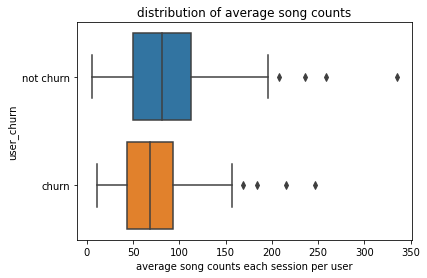

In [60]:
# average songs count per session distribution

df_avgsong_pd = df.groupby(['user_churn', 'userId', 'sessionId']).count()\
    .groupby(['user_churn', 'userId']).agg({'count': 'avg'})\
        .groupby(['user_churn','userId']).agg({'avg(count)':'mean'}).toPandas()

# display in boxplot

sns.boxplot(data=df_avgsong_pd, y='user_churn', x='avg(avg(count))', orient='h')

plt.xlabel('average song counts each session per user')
plt.ylabel('user_churn')
plt.yticks([0, 1], ['not churn', 'churn'])
plt.title('distribution of average song counts')
plt.show()

In [46]:
# users having higher average songs counts tend to not churn
# however the results are not significant

# 1.4.2.2 Membership Period

In [47]:
# time since registration
# create new column of date difference between the event date and the registration date
# then select the longest oneas membership period

df_membership_pd = df.select('userId', 'registration', 'ts', 'user_churn')\
    .withColumn('lifetime', (df.ts - df.registration))\
        .groupBy('userId', 'user_churn')\
            .agg({'lifetime': 'max'})\
                .withColumnRenamed('max(lifetime)', 'lifetime')\
                    .select('userId', 'user_churn', (col('lifetime')/1000/3600/24).alias('lifetime'))\
                        .toPandas()

df_membership_pd.head()

,userId,user_churn,lifetime
0,100010,0,55.643657
1,200002,0,70.074630
2,125,1,71.316887
3,124,0,131.555914
4,51,1,19.455845


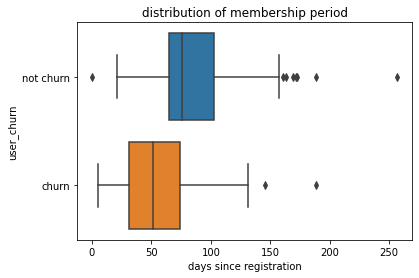

In [58]:
# display in boxplot

sns.boxplot(data=df_membership_pd, y='user_churn', x='lifetime', orient='h')

plt.xlabel('days since registration')
plt.ylabel('user_churn')
plt.yticks([0, 1], ['not churn', 'churn'])
plt.title('distribution of membership period')
plt.show()

In [51]:
# users that churned have an average of around 50 days membership period
# which means if the first 50 days of a new user is crucial to avoiding churning

# 1.4.2.3 No of Friends

In [52]:
# signaled by the appearance of 'Add Friend' in 'page'

df_friends_pd = df.where('page ==  "Add Friend"').groupby(['user_churn', 'userId']).count()\
    .toPandas()

df_friends_pd.head()

,user_churn,userId,count
0,0,100010,4
1,0,200002,4
2,0,124,74
3,1,51,28
4,0,7,1


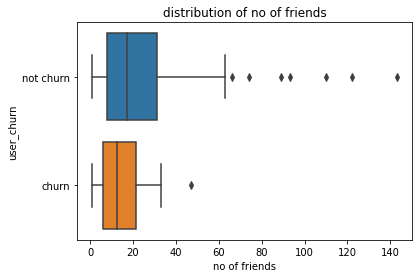

In [59]:
# display in boxplot

sns.boxplot(data=df_friends_pd, y='user_churn', x='count', orient='h')

plt.xlabel('no of friends')
plt.ylabel('user_churn')
plt.yticks([0, 1], ['not churn', 'churn'])
plt.title('distribution of no of friends')
plt.show()

In [54]:
# around 75% of users that churned have less than 20 friends on the platform
# therefore no of friends can serve as one of the indicators of possible churning users
# however the difference between users churned and not churned is not significant

# 1.4.2.4 Page Events

In [40]:
# create pivot table

df_page_pd = df.groupby(['userId']).pivot('page').count().fillna(0).toPandas()
df_page_pd.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


In [41]:
# assuming the appearance of 'Cancellation Confirmation' as a signal of churning
# change the column name

df_page_pd = df_page_pd.rename(columns={'Cancellation Confirmation':'Churn'})
df_page_pd.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


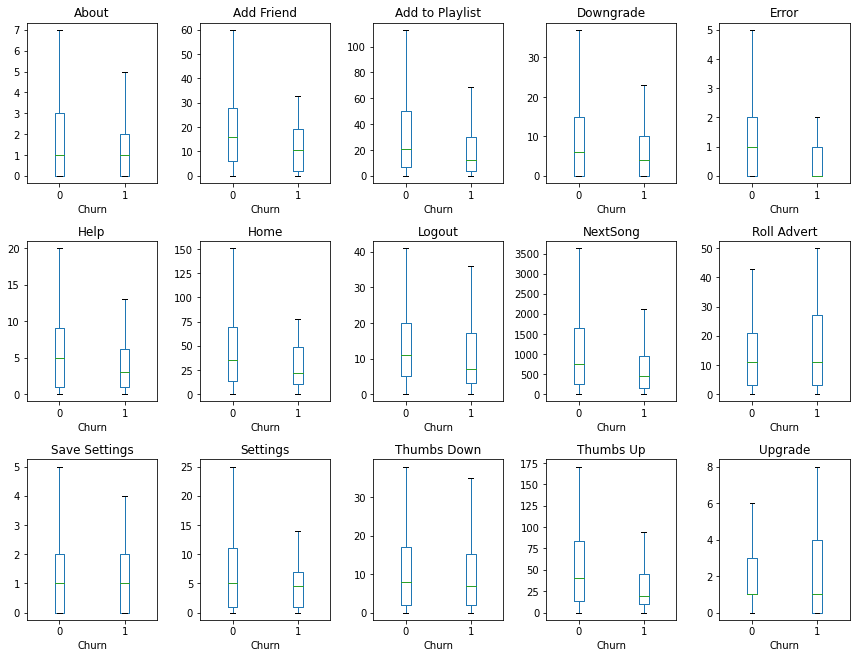

In [52]:
# present in boxplots

# create figure
fig = plt.figure(figsize=(12, 12))

selected_columns = [
    'About', 'Add Friend', 'Add to Playlist', 'Downgrade',
    'Error', 'Help', 'Home', 'Logout', 
    'NextSong', 'Roll Advert', 'Save Settings', 'Settings',
    'Thumbs Down', 'Thumbs Up', 'Upgrade'
]

for i, coln in enumerate(selected_columns):

    # append axes
    ax = fig.add_subplot(4,5,i+1)
    
    # boxplot
    df_page_pd.boxplot(coln, ax=ax, grid=False,  by='Churn', showfliers=False)

fig.suptitle('')
plt.tight_layout()
plt.show()

In [46]:
# In general, users churned have less engagement than users not churned
# however, most of which do not show significant insights if we consider interquartile range only
# noted that 'Thumbs Up' presented a little information about those users not churned
# it is safe to state that if a user give more than 50 thumbs up, the user will probably not churned
# this provide a benchmark for the user experience team to identify the group of potential churn users

# 1.4.2.5 Locations

In [55]:
# import region data
region = spark.read.csv('region.csv', header=True)

# create function for 'churn' labelling
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

# create function for 'location' splitting
func_location = udf(lambda x: x.split(', ')[1].split('-')[0])

# show the procressed 'location'
locations = df.withColumn('location', func_location(df['location']))\
    .select(['userId', 'location', 'user_churn']).drop_duplicates(subset=['userId'])

# join data with region data
locations = locations.join(region, locations['location'] == region['State Code'], how='left')\
    .select(['userId', col('Division').alias('location'), col('user_churn').alias('churn')])\
        .withColumn('churn', func_churn_label('churn'))

locations_pd = locations.toPandas()

# show the aggregate results
locations_count = locations_pd.groupby(['location', 'churn']).count().unstack().fillna(0)['userId']
locations_count['total'] = locations_count.sum(axis=1)

locations_count.head()

churn,Churn,Not Churn,total
location,,,
East North Central,8.0,16.0,24.0
East South Central,7.0,7.0,14.0
Middle Atlantic,8.0,23.0,31.0
Mountain,5.0,13.0,18.0
New England,0.0,16.0,16.0


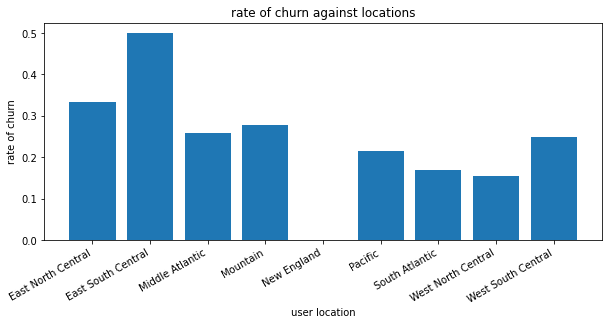

In [59]:
# display in bar chart

plt.figure(figsize=(10,4))
plt.bar(locations_count.index, locations_count['Churn'] / locations_count['total'])

plt.title('rate of churn against locations')
plt.xticks(rotation=30, ha='right')
plt.xlabel('user location')
plt.ylabel('rate of churn')
plt.show()

In [ ]:
# 'East South Central', 'East North Central' and 'West South Central' are the 3 regions with highest rate of churn
# Geographically, the three regions are nearby so the results are sound
# development team should look into the user group of these area, to see if they have a different user behaviour
# and make adjustment to the algorithm
# further study is needed for the perfect zero rate of churn in 'New England'

In [ ]:
# END